In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Data Cleaning

# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

df['MotorVehicleTheft'] = df['Motor Vehicle Theft']
df = df.drop(columns=['Motor Vehicle Theft'])

In [6]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
0,Adams Village,1861,0,0,0,2,10,12,0,0,0
1,Addison Town and Village,2577,3,0,0,3,20,24,0,3,1
2,Akron Village,2846,3,0,0,1,15,16,0,3,0
3,Albany,97956,791,8,227,705,3243,4090,30,526,142
4,Albion Village,6388,23,0,4,53,165,223,3,16,5


In [7]:
df.corr()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
Population,1.000,0.999,0.987,0.998,0.971,0.998,0.996,0.991,0.999,0.992
Violent Crime,0.999,1.000,0.992,1.000,0.978,0.999,0.998,0.995,1.000,0.996
Murder,0.987,0.992,1.000,0.993,0.994,0.993,0.995,0.998,0.991,0.998
Robbery,0.998,1.000,0.993,1.000,0.980,0.999,0.998,0.995,1.000,0.997
Burglary,0.971,0.978,0.994,0.980,1.000,0.983,0.987,0.992,0.976,0.991
Larceny-Theft,0.998,0.999,0.993,0.999,0.983,1.000,1.000,0.996,0.999,0.997
Propertycrime,0.996,0.998,0.995,0.998,0.987,1.000,1.000,0.998,0.998,0.998
Rape,0.991,0.995,0.998,0.995,0.992,0.996,0.998,1.000,0.994,0.999
Aggravated_Assault,0.999,1.000,0.991,1.000,0.976,0.999,0.998,0.994,1.000,0.995
MotorVehicleTheft,0.992,0.996,0.998,0.997,0.991,0.997,0.998,0.999,0.995,1.000


In [8]:
df.describe()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,72.902,119.684,637.017,792.606,5.865,121.261,35.905
std,450037.368,2815.269,18.304,1031.033,924.949,6346.054,7659.725,60.425,1706.132,403.424
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,6.000,31.000,40.500,0.000,1.000,0.000
50%,7233.500,6.000,0.000,1.000,17.500,94.000,112.500,0.000,4.000,2.000
75%,18427.500,22.000,0.000,5.000,51.250,287.250,341.000,2.000,14.000,7.000
max,8396126.000,52384.000,335.000,19170.000,16606.000,117931.000,141971.000,1112.000,31767.000,7434.000


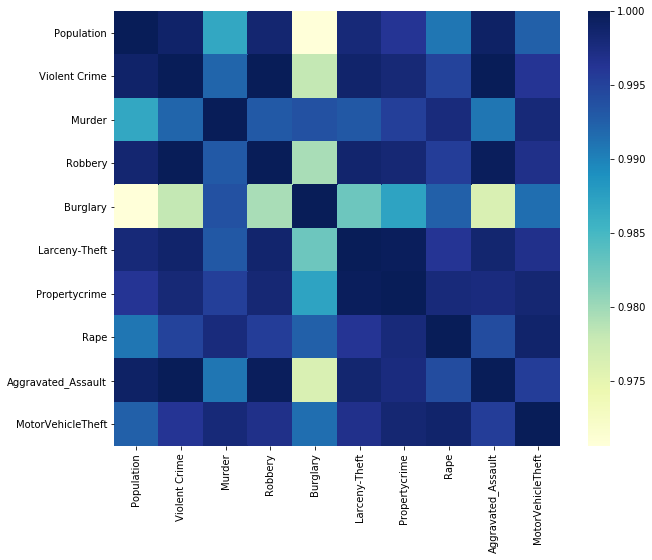

In [9]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap="YlGnBu")

In [10]:
# Create more Features

# Combine variance of Violent Crime, Aggravated_Assault and Larceny-Theft
means = df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']].mean(axis=0)
stds = df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']].std(axis=0)
df['Violent_Assault_Larcency'] = ((df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']] - means)/stds).mean(axis=1)

# Combine variance of Rape and MotorVehicleTheft
means = df[['Rape', 'MotorVehicleTheft']].mean(axis=0)
stds = df[['Rape', 'MotorVehicleTheft']].std(axis=0)
df['Rape_MotorVehicleTheft'] = ((df[['Rape', 'MotorVehicleTheft']] - means)/stds).mean(axis=1)

# Create Features: Population_squared, Murder binary, Robbery, binary
df['Population_squared'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Robbery'] = np.where(df['Robbery']>0, '1', '0')

#Convert new columns to int
df[['Population_squared', 'Murder', 'Robbery']] = df[['Population_squared',
       'Murder', 'Robbery']].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 14 columns):
City                        348 non-null object
Population                  348 non-null int64
Violent Crime               348 non-null int64
Murder                      348 non-null int64
Robbery                     348 non-null int64
Burglary                    348 non-null int64
Larceny-Theft               348 non-null int64
Propertycrime               348 non-null int64
Rape                        348 non-null int64
Aggravated_Assault          348 non-null int64
MotorVehicleTheft           348 non-null int64
Violent_Assault_Larcency    348 non-null float64
Rape_MotorVehicleTheft      348 non-null float64
Population_squared          348 non-null int64
dtypes: float64(2), int64(11), object(1)
memory usage: 40.8+ KB


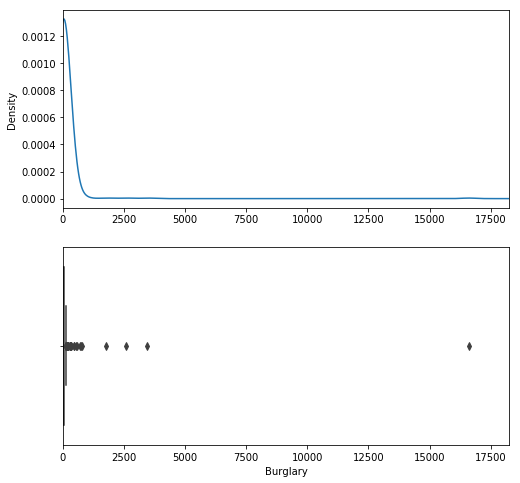

In [12]:
# Log transform Burglary Variable and remove Outliers

i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [13]:
# Remove any zeros (otherwise we get (-inf)
df.loc[df.Burglary == 0, 'Burglary'] = np.nan

# Drop Na
df.dropna(inplace=True)

# Log Transformation
df['log_' + i] = np.log(df[i])

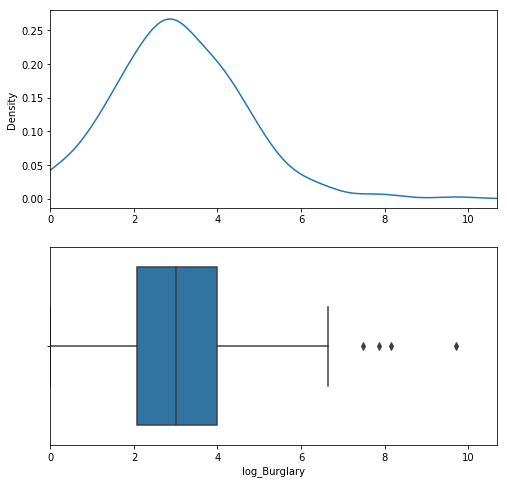

In [14]:
# Visualize Logged distribution
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [15]:
q75,q25 = np.percentile(df.log_Burglary.dropna(), [75,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

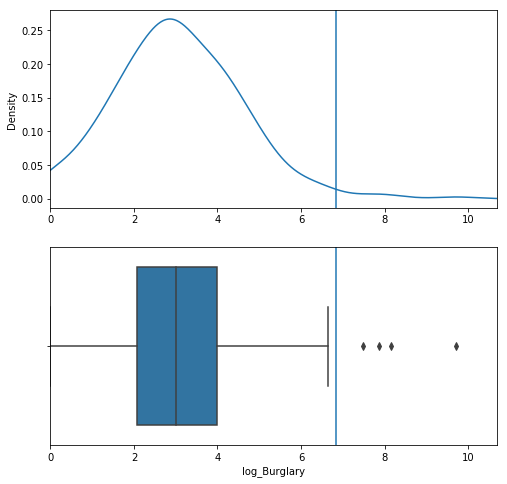

In [16]:
# Visualize Outliers
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [17]:
# Remove Outliers
df['Outliers'] = 0

df.loc[df[i] < min, 'Outliers'] = 1
df.loc[df[i] > max, 'Outliers'] = 1

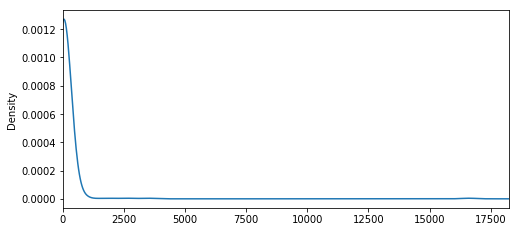

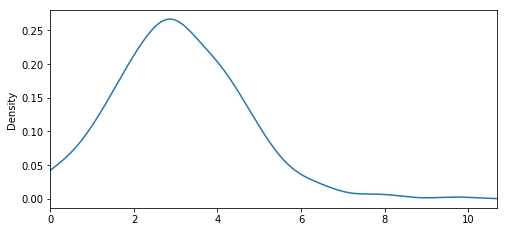

In [18]:
# Compare original Data with cleaned, log transformed data
i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

i = 'log_Burglary'
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

In [19]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft,Violent_Assault_Larcency,Rape_MotorVehicleTheft,Population_squared,log_Burglary,Outliers
0,Adams Village,1861,0,0,0,2.000,10,12,0,0,0,-0.080,-0.093,3463321,0.693,0
1,Addison Town and Village,2577,3,0,0,3.000,20,24,0,3,1,-0.079,-0.092,6640929,1.099,0
2,Akron Village,2846,3,0,0,1.000,15,16,0,3,0,-0.079,-0.093,8099716,0.000,0
3,Albany,97956,791,1,1,705.000,3243,4090,30,526,142,0.286,0.331,9595377936,6.558,0
4,Albion Village,6388,23,0,1,53.000,165,223,3,16,5,-0.067,-0.062,40806544,3.970,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 0 to 347
Data columns (total 16 columns):
City                        327 non-null object
Population                  327 non-null int64
Violent Crime               327 non-null int64
Murder                      327 non-null int64
Robbery                     327 non-null int64
Burglary                    327 non-null float64
Larceny-Theft               327 non-null int64
Propertycrime               327 non-null int64
Rape                        327 non-null int64
Aggravated_Assault          327 non-null int64
MotorVehicleTheft           327 non-null int64
Violent_Assault_Larcency    327 non-null float64
Rape_MotorVehicleTheft      327 non-null float64
Population_squared          327 non-null int64
log_Burglary                327 non-null float64
Outliers                    327 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 43.4+ KB


In [21]:
# Compile Features
features = pd.DataFrame()
features = df.drop(columns=['City', 'Population', 'Burglary', 'Larceny-Theft', 'Outliers', 'Aggravated_Assault', 'Violent Crime', 'Rape', 'Robbery', 'MotorVehicleTheft'])
features.head()

,Murder,Propertycrime,Violent_Assault_Larcency,Rape_MotorVehicleTheft,Population_squared,log_Burglary
0,0,12,-0.080,-0.093,3463321,0.693
1,0,24,-0.079,-0.092,6640929,1.099
2,0,16,-0.079,-0.093,8099716,0.000
3,1,4090,0.286,0.331,9595377936,6.558
4,0,223,-0.067,-0.062,40806544,3.970


In [22]:
# Run Model
regr = linear_model.LinearRegression()
y = features['Propertycrime'].values.reshape(-1, 1)
x = features.drop(columns=['Propertycrime'])
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[-6.51622002e+01  1.22178044e+04 -5.72726084e+02 -1.06616120e-09
   5.52223493e+01]]

Intercept: 
 [855.13416354]

R-squared:
 0.9995824688697904


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [23]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.9541282536475484
Testing on sample:0.9995824688697904


In [24]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([   0.98279232,    0.89593232,    0.80762285, -178.20284696,
          0.9370992 ])

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 0 to 347
Data columns (total 6 columns):
Murder                      327 non-null int64
Propertycrime               327 non-null int64
Violent_Assault_Larcency    327 non-null float64
Rape_MotorVehicleTheft      327 non-null float64
Population_squared          327 non-null int64
log_Burglary                327 non-null float64
dtypes: float64(3), int64(3)
memory usage: 17.9 KB


In [26]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population_squared+Murder+Rape_MotorVehicleTheft+log_Burglary+Violent_Assault_Larcency'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=features).fit()

In [27]:
lm.params

Intercept                    855.266
Population_squared            -0.000
Murder                       -65.664
Rape_MotorVehicleTheft      -574.885
log_Burglary                  55.222
Violent_Assault_Larcency   12220.757
dtype: float64

In [28]:
lm.pvalues

Intercept                  0.000
Population_squared         0.000
Murder                     0.032
Rape_MotorVehicleTheft     0.043
log_Burglary               0.000
Violent_Assault_Larcency   0.000
dtype: float64